### Student Information
Name: Erdenejargal

Student ID: 113065430

GitHub ID: ErkaGlt

Kaggle name: Erdenejargal Galtsuren

Kaggle private scoreboard snapshot: 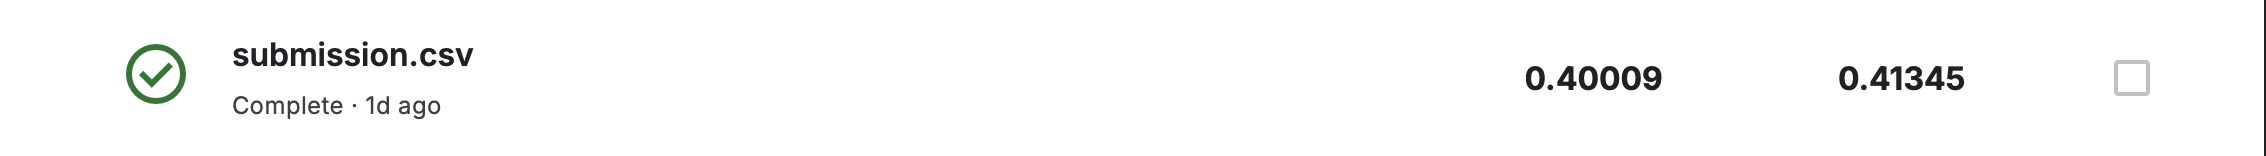

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home exercises** in the [DM2024-Lab2-master Repo](https://github.com/didiersalazar/DM2024-Lab2-Master). You may need to copy some cells from the Lab notebook to this notebook.


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework) regarding Emotion Recognition on Twitter by this link: https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework. The scoring will be given according to your place in the Private Leaderboard ranking:
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (0.6N + 1 - x) / (0.6N) * 10 + 20 points, where N is the total number of participants, and x is your rank. (ie. If there are 100 participants and you rank 3rd your score will be (0.6 * 100 + 1 - 3) / (0.6 * 100) * 10 + 20 = 29.67% out of 30%.)   
    Submit your last submission **BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)**. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developing the model for the competition (You can use code and comment on it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained.


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)__.

## 1. Data PreProcessing

For the following steps i loaded a JSON file with tweet data, extracting the tweet ID and text, and combined it with additional CSV files containing emotion labels and identification metadata. The datasets were merged using the tweet ID to include relevant information such as whether a tweet is for training or testing and its corresponding emotion label (if available). Also checked for missing values and found that some rows in the emotion column were incomplete in test dataset, but other key columns like tweet ID and text were complete. Finally, the cleaned and organized dataset was saved as merged_dataset.csv, ready for further analysis and modeling.

In [1]:
import pandas as pd
import json

# File import
json_file_path = "/content/tweets_DM.json"
emotion_file_path = "/content/emotion.csv"
data_identification_file_path = "/content/data_identification.csv"

In [2]:
# Parsing the JSON file line by line
parsed_tweets = []
with open(json_file_path, 'r') as file:
    for line in file:
        tweet = json.loads(line.strip())  # Load each line as a JSON object
        parsed_tweets.append({
            "tweet_id": tweet["_source"]["tweet"]["tweet_id"],
            "text": tweet["_source"]["tweet"]["text"]
        })

# Converting parsed tweets into a DataFrame
tweets_df = pd.DataFrame(parsed_tweets)

In [3]:
# Loading emotion.csv and data_identification.csv
emotion_df = pd.read_csv(emotion_file_path)
data_identification_df = pd.read_csv(data_identification_file_path)

In [4]:
# Merging datasets
# Step 1: Merging tweets_df with data_identification_df on 'tweet_id'
merged_df = pd.merge(tweets_df, data_identification_df, on="tweet_id", how="inner")

In [5]:
# Step 2: Merging the result with emotion_df on 'tweet_id'
# This will only join emotion labels for the training set
final_df = pd.merge(merged_df, emotion_df, on="tweet_id", how="left")

In [6]:
# Display the final DataFrame
print(final_df.head())

# Save the merged DataFrame for further processing
final_df.to_csv("merged_dataset.csv", index=False)

   tweet_id                                               text identification  \
0  0x376b20  People who post "add me on #Snapchat" must be ...          train   
1  0x2d5350  @brianklaas As we see, Trump is dangerous to #...          train   
2  0x28b412  Confident of your obedience, I write to you, k...           test   
3  0x1cd5b0                Now ISSA is stalking Tasha 😂😂😂 <LH>          train   
4  0x2de201  "Trust is not the same as faith. A friend is s...           test   

        emotion  
0  anticipation  
1       sadness  
2           NaN  
3          fear  
4           NaN  


In [7]:
final_df.head(5)

,tweet_id,text,identification,emotion
0,0x376b20,"People who post ""add me on #Snapchat"" must be ...",train,anticipation
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...",train,sadness
2,0x28b412,"Confident of your obedience, I write to you, k...",test,NaN
3,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,train,fear
4,0x2de201,"""Trust is not the same as faith. A friend is s...",test,NaN


In [8]:
num_rows = final_df.shape[0]
print(f"Number of rows in the dataset: {num_rows}")

nan_counts = final_df.isnull().sum()
print(nan_counts)

Number of rows in the dataset: 1867535
tweet_id               0
text                   0
identification         0
emotion           411972
dtype: int64


In [9]:
# Checking the distribution of 'identification' for missing 'emotion'
missing_emotion = final_df[final_df['emotion'].isnull()]
print(missing_emotion['identification'].value_counts())

identification
test    411972
Name: count, dtype: int64


## 2. Text PreProcessing
The text preprocessing started by cleaning the text data, including removing URLs, mentions, and special characters, while retaining meaningful elements like hashtags and emojis. Emojis were replaced with their textual descriptions for better analysis, and the text was standardized by converting it to lowercase and removing extra spaces. Additional features like text length, hashtag count, and emoji count were calculated and added as new columns to enhance the data. Finally, TF-IDF vectorization was applied to convert the cleaned text into numerical features, and these were combined with the additional features for modeling. These steps prepared the text data for accurate and efficient analysis.

In [10]:
# Spliting into training and test datasets
train_df = final_df[final_df['identification'] == 'train'].dropna(subset=['emotion'])
test_df = final_df[final_df['identification'] == 'test']

print(f"Training set size: {train_df.shape[0]}")
print(f"Test set size: {test_df.shape[0]}")

Training set size: 1455563
Test set size: 411972


In [11]:
pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 7.7 MB/s eta 0:00:00


In [12]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import emoji  # Importing emoji library for emoji detection

# Function to clean the text, handle emojis, and include hashtags
def preprocess_text(text):
    # Removing URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Extracting hashtags (keep them in the text for context)
    hashtags = re.findall(r'#\w+', text)  # Extract hashtags
    hashtag_text = ' '.join(hashtags)  # Join hashtags as a space-separated string

    # Removing mentions (but keep hashtags)
    text = re.sub(r'@\w+', '', text)

    # Extracting emojis and append their descriptions to the text
    emojis = ''.join(c for c in text if c in emoji.EMOJI_DATA)
    emoji_text = ' '.join(emoji.demojize(e) for e in emojis)

    # Appending emoji descriptions and hashtags to the text
    text += ' ' + emoji_text + ' ' + hashtag_text

    # Removing special characters and numbers (except hashtags)
    text = re.sub(r'[^a-zA-Z#\s]', '', text)

    # Converting text to lowercase
    text = text.lower()

    # Removing extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [13]:
# Applying text preprocessing to the training data
train_df['cleaned_text'] = train_df['text'].apply(preprocess_text)

# Applying the same preprocessing to the test data
test_df['cleaned_text'] = test_df['text'].apply(preprocess_text)

<ipython-input-13-1d67411e856e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['cleaned_text'] = test_df['text'].apply(preprocess_text)


In [14]:
# Adding additional features AFTER preprocessing
# Adding text length as a feature
train_df['text_length'] = train_df['text'].apply(len)
test_df['text_length'] = test_df['text'].apply(len)

<ipython-input-14-8fb639cc50e2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['text_length'] = test_df['text'].apply(len)


In [15]:
# Adding hashtag count as a feature
train_df['hashtag_count'] = train_df['text'].apply(lambda x: len(re.findall(r'#\w+', x)))
test_df['hashtag_count'] = test_df['text'].apply(lambda x: len(re.findall(r'#\w+', x)))

# Adding emoji count as a feature
train_df['emoji_count'] = train_df['text'].apply(lambda x: sum(c in emoji.EMOJI_DATA for c in x))
test_df['emoji_count'] = test_df['text'].apply(lambda x: sum(c in emoji.EMOJI_DATA for c in x))

<ipython-input-15-b2ba003671fb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['hashtag_count'] = test_df['text'].apply(lambda x: len(re.findall(r'#\w+', x)))
<ipython-input-15-b2ba003671fb>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['emoji_count'] = test_df['text'].apply(lambda x: sum(c in emoji.EMOJI_DATA for c in x))


In [21]:
# Initializing TF-IDF Vectorizer with stop words removal and bigrams
#tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), stop_words='english')  # Includes unigrams and bigrams
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), min_df=5, max_df=0.8, stop_words='english')


# Fiting and transform the training text
X_train = tfidf.fit_transform(train_df['cleaned_text'])

# Transforming the test text (without fitting again)
X_test = tfidf.transform(test_df['cleaned_text'])

# Combining TF-IDF features with additional features
X_train_combined = hstack([X_train, train_df[['text_length', 'hashtag_count', 'emoji_count']].values])
X_test_combined = hstack([X_test, test_df[['text_length', 'hashtag_count', 'emoji_count']].values])

# Checking the resulting dimensions
print(f"Combined TF-IDF and feature matrix for training data: {X_train_combined.shape}")
print(f"Combined TF-IDF and feature matrix for test data: {X_test_combined.shape}")

Combined TF-IDF and feature matrix for training data: (1455563, 10003)
Combined TF-IDF and feature matrix for test data: (411972, 10003)


In [23]:
from sklearn.preprocessing import LabelEncoder

# Encoding target labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['emotion'])

# Checking label mapping
print(f"Label classes: {label_encoder.classes_}")

Label classes: ['anger' 'anticipation' 'disgust' 'fear' 'joy' 'sadness' 'surprise'
 'trust']


## 3. Model Evaluation and Prediction
The SVM model was trained on the training dataset and evaluated on the validation dataset, achieving an accuracy of 55.21%. Using the trained model, predictions were made on the test dataset, and the predicted emotions were decoded back to their original labels. The results, including the tweet_id and predicted_emotion, were saved to a CSV file named svm_test_predictions.csv for further use.

In [24]:
from sklearn.model_selection import train_test_split

# Spliting training data into train and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train_combined, y_train, test_size=0.2, random_state=42
)

print(f"Train split shape: {X_train_split.shape}")
print(f"Validation split shape: {X_val.shape}")

Train split shape: (1164450, 10003)
Validation split shape: (291113, 10003)


In [25]:
from sklearn.svm import LinearSVC
svc_model = LinearSVC(max_iter=1000)
svc_model.fit(X_train_split, y_train_split)
val_accuracy = svc_model.score(X_val, y_val)
print(f"Validation Accuracy with SVM: {val_accuracy:.4f}")

Validation Accuracy with SVM: 0.5521


In [26]:
# Applying the trained SVM model on the test dataset
# Ensuring that 'X_test_combined' is the feature matrix for your test data
test_predictions_svm = svc_model.predict(X_test_combined)

# Decoding the predicted labels back to their original emotion names
test_predicted_emotions = label_encoder.inverse_transform(test_predictions_svm)

# Adding the predictions as a new column to your test DataFrame
test_df['predicted_emotion'] = test_predicted_emotions

# Selecting only the 'tweet_id' and 'predicted_emotion' columns for the result
result_df = test_df[['tweet_id', 'predicted_emotion']]

# Saving the result to a CSV file
result_df.to_csv("svm_test_predictions.csv", index=False)

print("Test predictions saved to 'svm_test_predictions.csv'")
result_df.head(10)

<ipython-input-26-78691bed80ba>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_emotion'] = test_predicted_emotions


Test predictions saved to 'svm_test_predictions.csv'


,tweet_id,predicted_emotion
2,0x28b412,anticipation
4,0x2de201,anticipation
9,0x218443,joy
30,0x2939d5,anticipation
33,0x26289a,trust
35,0x31c6e0,joy
37,0x32edee,trust
46,0x3714ee,anger
49,0x235628,joy
56,0x283024,sadness


### **Conclusion**:
I experimented with various models, including Naive Bayes (NB), SVM, XGBoost, and LightGBM, to classify emotions in the dataset. While NB and some other models showed lower accuracy compared to SVM, the SVM model provided a validation accuracy of 55.21%, making it the most effective among the models tried. Attempts to use more complex models like XGBoost and LightGBM were hindered by their resource demands, which caused performance issues in my Google Colab environment. Based on these findings, SVM was selected as the most suitable model for this task given its balance of performance and computational efficiency.

In [27]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

nb_model = MultinomialNB()
nb_model.fit(X_train_split, y_train_split)
y_val_pred_nb = nb_model.predict(X_val)
nb_val_accuracy = accuracy_score(y_val, y_val_pred_nb)
print(f"Validation Accuracy with Naive Bayes: {nb_val_accuracy:.4f}")

# Detailed classification report for Naive Bayes
print("\nClassification Report for Naive Bayes:")
print(classification_report(y_val, y_val_pred_nb, target_names=label_encoder.classes_))

Validation Accuracy with Naive Bayes: 0.5175

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

       anger       0.70      0.20      0.31      7946
anticipation       0.56      0.53      0.54     49984
     disgust       0.41      0.41      0.41     27669
        fear       0.51      0.33      0.40     12846
         joy       0.55      0.74      0.63    102943
     sadness       0.41      0.50      0.45     38745
    surprise       0.71      0.16      0.27      9816
       trust       0.60      0.23      0.34     41164

    accuracy                           0.52    291113
   macro avg       0.55      0.39      0.42    291113
weighted avg       0.53      0.52      0.50    291113

